In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [125]:
import os
import random
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [126]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/dtd


In [127]:
# 사용할 폴더로 이동
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


---
# 이미지 데이터 불러온 뒤 확인

---

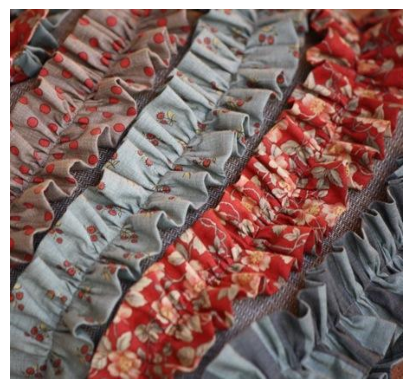

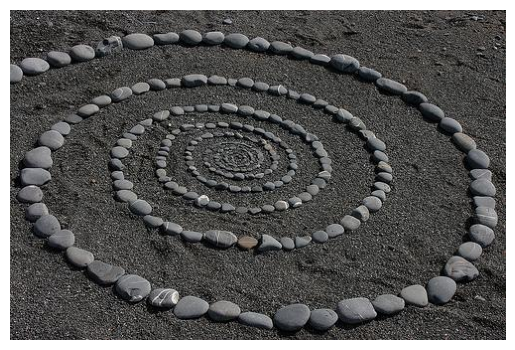

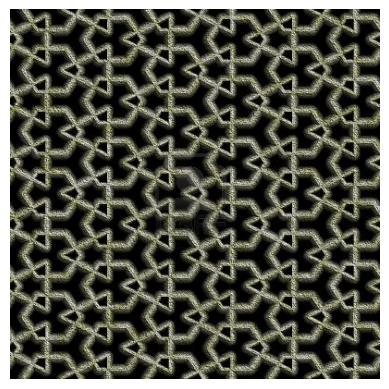

In [118]:
# 텍스트 파일 경로
txt_file = "dtd/labels/test1.txt"

# 이미지 파일들을 저장할 리스트
test_image_files = []

# 텍스트 파일 열기
with open(txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄 끝의 개행문자 제거 후 이미지 파일 경로 추가
        test_image_files.append(line.strip())

# 랜덤하게 3개의 이미지 파일을 선택
random_image_files = random.sample(test_image_files, 3)

# 랜덤하게 선택된 이미지 파일들을 확인
for image_file in random_image_files:
    # 이미지 파일 경로 생성
    image_path = os.path.join("dtd/images", image_file)
    # 이미지 열기
    image = Image.open(image_path)
    # 이미지 확인
    plt.imshow(image)
    plt.axis('off')
    plt.show()


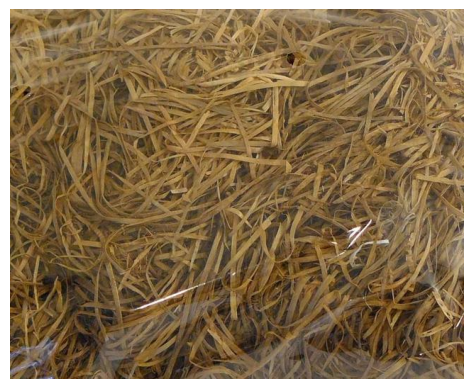

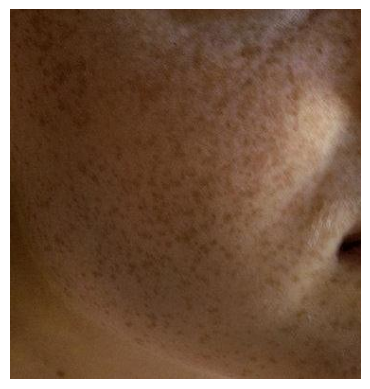

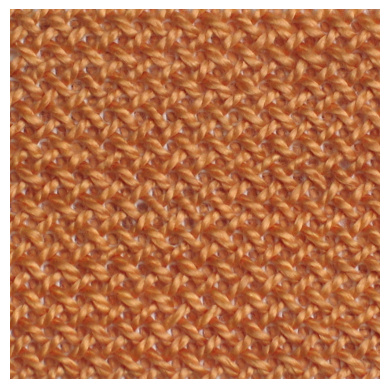

In [119]:
# 텍스트 파일 경로
train_txt_file = "dtd/labels/train1.txt"

# 이미지 파일들을 저장할 리스트
train_image_files = []

# 텍스트 파일 열기
with open(train_txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄 끝의 개행문자 제거 후 이미지 파일 경로 추가
        train_image_files.append(line.strip())

# 랜덤하게 3개의 이미지 파일을 선택
random_image_files = random.sample(train_image_files, 3)

# 랜덤하게 선택된 이미지 파일들을 확인
for image_file in random_image_files:
    # 이미지 파일 경로 생성
    image_path = os.path.join("dtd/images", image_file)
    # 이미지 열기
    image = Image.open(image_path)
    # 이미지 확인
    plt.imshow(image)
    plt.axis('off')
    plt.show()

---
# 라벨 10개인 데이터 학습

---

In [175]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# 텍스트 파일 경로
train_txt_file = "dtd/labels/train1.txt"
test_txt_file = "dtd/labels/test1.txt"

# 이미지 파일들을 저장할 리스트
train_image_files = []
test_image_files = []

# 텍스트 파일 열기
with open(train_txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄을 공백으로 분할하여 이미지 파일 경로 추출
        image_file = line.strip().split()[0]
        train_image_files.append(image_file)

with open(test_txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄을 공백으로 분할하여 이미지 파일 경로 추출
        image_file = line.strip().split()[0]
        test_image_files.append(image_file)

# 레이블 딕셔너리 생성
label_to_idx = {label: idx for idx, label in enumerate(sorted(set([image_file.split("/")[0] for image_file in train_image_files])))}

# 이미지의 평균과 표준편차 계산
def compute_mean_std(image_files):
    mean = 0.
    std = 0.
    num_samples = 0

    for image_file in image_files:
        image_path = os.path.join("dtd/images", image_file)
        image = Image.open(image_path)
        image = transforms.ToTensor()(image)  # PIL 이미지를 텐서로 변환
        mean += image.mean(dim=(1, 2))
        std += image.std(dim=(1, 2))
        num_samples += 1

    mean /= num_samples
    std /= num_samples

    return mean, std

# 평균과 표준편차 계산
mean, std = compute_mean_std(train_image_files)

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # 평균과 표준편차 적용
])

# 이미지 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, image_files, label_to_idx, transform=None):
        self.image_files = image_files
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join("dtd/images", image_file)
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        # 이미지 파일 이름에서 레이블 추출하여 인덱스로 변환
        label = self.label_to_idx[image_file.split("/")[0]]
        return image, label

# 훈련 데이터셋 로드
train_dataset = CustomDataset(train_image_files, label_to_idx, transform=transform)
test_dataset = CustomDataset(test_image_files, label_to_idx, transform=transform)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 정의
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # 이미지 크기가 100x100으로 조정되었으므로
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = MyCNN(len(label_to_idx))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
test_losses = []
test_accuracies = []

# 훈련 함수
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 정확도 계산
    accuracy = 100. * correct / total
    print(f'Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 모델 평가
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # 평균 테스트 손실 계산
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # 정확도 계산
    accuracy = 100. * correct / total
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# 학습
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)


Training Loss: 2.2957, Accuracy: 10.75%
Test Loss: 2.2962, Accuracy: 10.00%
Training Loss: 2.2863, Accuracy: 11.50%
Test Loss: 2.2916, Accuracy: 12.00%
Training Loss: 2.2721, Accuracy: 12.25%
Test Loss: 2.2802, Accuracy: 12.75%
Training Loss: 2.2655, Accuracy: 12.25%
Test Loss: 2.2727, Accuracy: 13.50%
Training Loss: 2.2540, Accuracy: 14.00%
Test Loss: 2.2701, Accuracy: 18.75%
Training Loss: 2.2323, Accuracy: 17.50%
Test Loss: 2.2536, Accuracy: 17.25%
Training Loss: 2.2257, Accuracy: 18.50%
Test Loss: 2.2354, Accuracy: 17.50%
Training Loss: 2.1932, Accuracy: 17.75%
Test Loss: 2.2060, Accuracy: 18.25%
Training Loss: 2.1980, Accuracy: 19.75%
Test Loss: 2.2313, Accuracy: 21.75%
Training Loss: 2.1585, Accuracy: 23.25%
Test Loss: 2.2117, Accuracy: 20.25%


---
# 꾸준히 정확도가 증가하고 loss는 떨어지지만 전체적으로 값이 너무 작아 데이터 증강

---

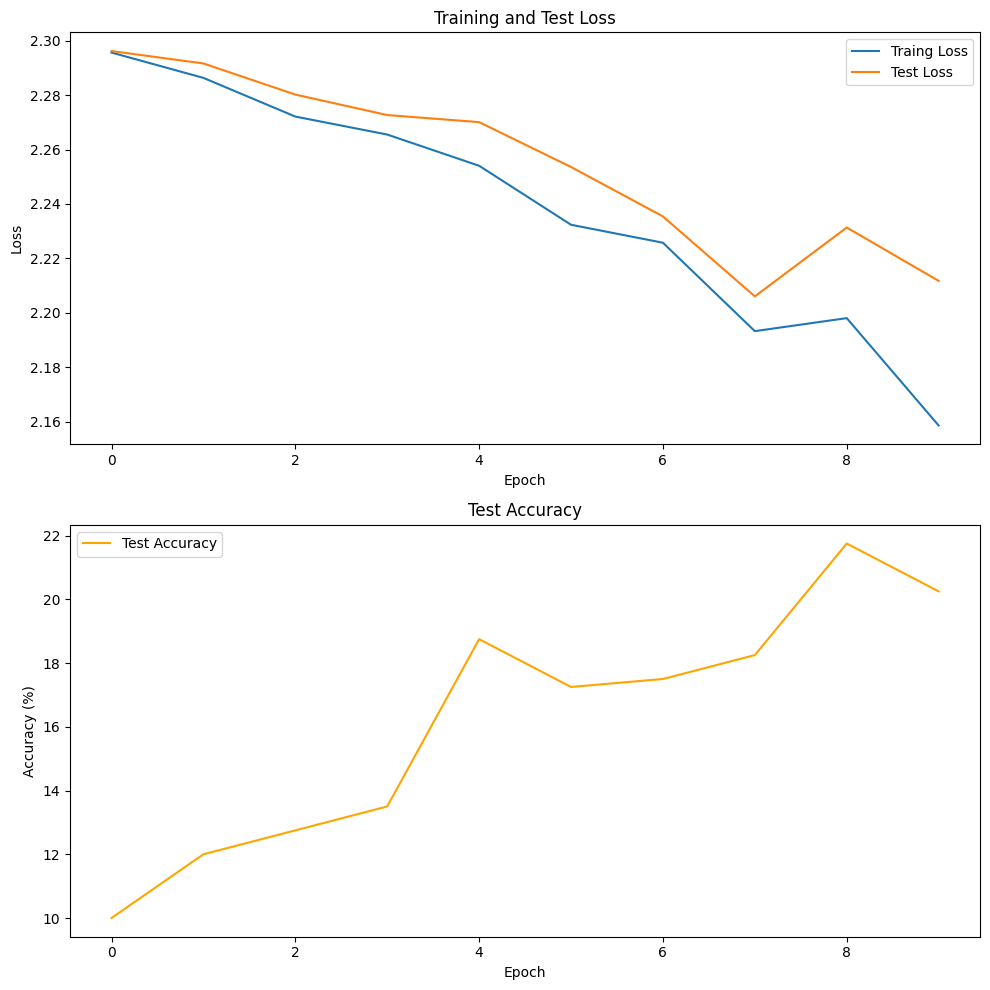

In [176]:
# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize = (10, 10))
axs[0].plot(train_losses, label = 'Traing Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(test_accuracies, label = 'Test Accuracy', color = 'orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Test Accuracy')

plt.tight_layout()
plt.show()

In [187]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# 텍스트 파일 경로
train_txt_file = "dtd/labels/train1.txt"
test_txt_file = "dtd/labels/test1.txt"

# 이미지 파일들을 저장할 리스트
train_image_files = []
test_image_files = []

# 텍스트 파일 열기
with open(train_txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄을 공백으로 분할하여 이미지 파일 경로 추출
        image_file = line.strip().split()[0]
        train_image_files.append(image_file)

with open(test_txt_file, "r") as file:
    # 각 줄을 읽어오면서 이미지 파일 경로를 리스트에 추가
    for line in file:
        # 줄을 공백으로 분할하여 이미지 파일 경로 추출
        image_file = line.strip().split()[0]
        test_image_files.append(image_file)

# 레이블 딕셔너리 생성
label_to_idx = {label: idx for idx, label in enumerate(sorted(set([image_file.split("/")[0] for image_file in train_image_files])))}

# 이미지의 평균과 표준편차 계산
def compute_mean_std(image_files):
    mean = 0.
    std = 0.
    num_samples = 0

    for image_file in image_files:
        image_path = os.path.join("dtd/images", image_file)
        image = Image.open(image_path)
        image = transforms.ToTensor()(image)  # PIL 이미지를 텐서로 변환
        mean += image.mean(dim=(1, 2))
        std += image.std(dim=(1, 2))
        num_samples += 1

    mean /= num_samples
    std /= num_samples

    return mean, std

# 평균과 표준편차 계산
mean, std = compute_mean_std(train_image_files)

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((100, 100)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  # 평균과 표준편차 적용
])

# 이미지 데이터셋 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, image_files, label_to_idx, transform=None):
        self.image_files = image_files
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join("dtd/images", image_file)

        # 이미지 불러오기
        image = cv2.imread(image_path)
        # BGR을 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            # PIL 이미지로 변환
            image = Image.fromarray(image)
            original_image = self.transform(image)

            # 좌우 반전
            flipped_image = transforms.functional.hflip(image)
            flipped_image = self.transform(flipped_image)

            # 레이블 가져오기
            label = self.label_to_idx[image_file.split("/")[0]]

            # 좌우 반전된 이미지와 레이블을 기존 데이터와 함께 반환
            return original_image, label, flipped_image, label

# 훈련 데이터셋 로드
train_dataset = CustomDataset(train_image_files, label_to_idx, transform=transform)
test_dataset = CustomDataset(test_image_files, label_to_idx, transform=transform)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델 정의
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # 이미지 크기가 100x100으로 조정되었으므로
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = MyCNN(len(label_to_idx))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_losses = []
test_losses = []
test_accuracies = []

# opencv를 사용하여 이미지 증강 함수 정의
def augment_image(image):
    # 이미지를 numpy 배열로 변환
    np_image = np.array(image)
    # 좌우 반전
    augmented_np_image = cv2.flip(np_image, 1)
    # PIL 이미지로 변환
    augmented_image = Image.fromarray(augmented_np_image)
    return augmented_image


# 훈련 함수
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for data, target, flipped_data, target in train_loader:
        optimizer.zero_grad()

        # Concatenate original and flipped images
        data = torch.cat((data, flipped_data), 0)
        target = torch.cat((target, target), 0)

        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # 정확도 계산
    accuracy = 100. * correct / total
    print(f'Training Loss: {train_loss:.4f}, Accuracy: {accuracy:.2f}%')


# 모델 평가
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target, _, _ in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    # 평균 테스트 손실 계산
    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    # 정확도 계산
    accuracy = 100. * correct / total
    test_accuracies.append(accuracy)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')


# 학습
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, criterion)
    test(model, test_loader)


Training Loss: 2.2949, Accuracy: 11.50%
Test Loss: 2.3027, Accuracy: 10.00%
Training Loss: 2.2843, Accuracy: 11.00%
Test Loss: 2.2909, Accuracy: 11.25%
Training Loss: 2.2791, Accuracy: 12.62%
Test Loss: 2.2779, Accuracy: 17.75%
Training Loss: 2.2575, Accuracy: 16.88%
Test Loss: 2.2619, Accuracy: 18.25%
Training Loss: 2.2373, Accuracy: 17.12%
Test Loss: 2.2570, Accuracy: 18.50%
Training Loss: 2.2316, Accuracy: 16.38%
Test Loss: 2.2262, Accuracy: 19.00%
Training Loss: 2.2212, Accuracy: 17.38%
Test Loss: 2.2321, Accuracy: 18.25%
Training Loss: 2.1943, Accuracy: 17.75%
Test Loss: 2.2150, Accuracy: 19.50%
Training Loss: 2.1979, Accuracy: 19.00%
Test Loss: 2.1756, Accuracy: 21.50%
Training Loss: 2.1854, Accuracy: 22.38%
Test Loss: 2.1676, Accuracy: 23.75%


---
# 좌우반전 데이터를 추가했음에도 큰 차이가 없음
# 향후 하이퍼파라미터 조절을 통해 더 나은 방향이 무엇인지 찾아보려 함
---